$\textbf{Latent Vairable Models:}$

Why would we do this???

One main benefit is if we assume that there are fewer latent than visible variables- now we can make a model with 
fewer parameters, and hence we will have less variance in our parameter estimation.


<img src="fig11.png">

$\textbf{Multimodal Distributions:}$

One hint that you might want to use a mixture model is if distribution appears multimodal.
Since Gaussian distribution is one of the most common distributions for unimodal data, it is one of the most popular for mixture models as well, so we will start by discussion GMM.


$\textbf{Gaussian Mixture Model}$

In practice, the most well known Latent Variable Model is the Gaussian Mixture Model.

So, GMM is like GDA, except that we don’t know the classes of the training data (sample data)
We find the maximum likelihood estimators.

Just like in GDA, our model is 
$$X|Y=y \sim N(\mu_y, \Sigma_y)$$
only now our class labels y are hidden, and we do not know many there are. Therefore, since we only see indistinguishable x we rewrite the model in the form
$$p(X=x) = \sum_y \pi_y N(x|\mu_y, \Sigma_y)$$
adding the $\pi_y$ term to account for "prior" class probability (recall that we did this in GDA too).

As before, we will attempt maximium likelihood estimation of the free parameters.

The likelihood function is not convex, so we may be stuck in a local optimum.

Once we have estimated the parameters, we can again computer the class/cluster probabilities of each point exactly as we did in GDA.



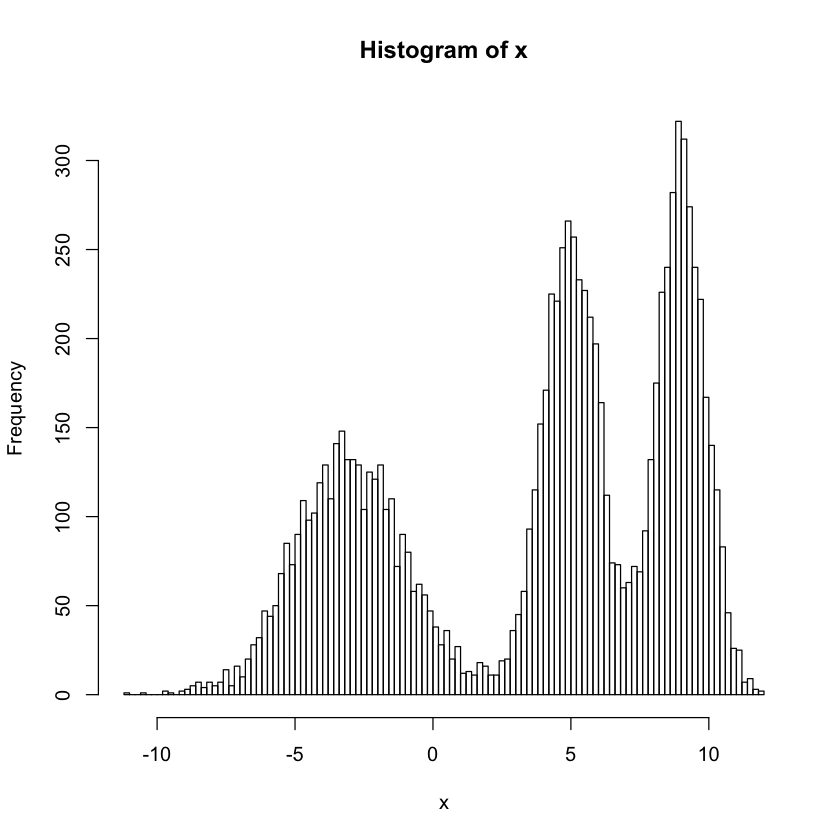

In [32]:
#Univariate Case:
x=rep(NA,10000)
x=sapply(x, function(x){
    class=sample(c(1,2,3), size=1,replace = TRUE, prob = c(1/3,1/3,1/3))
    return(c(rnorm(n=1,mean=-3,sd=2),rnorm(n=1,mean=5,sd=1),rnorm(n=1,mean=9,sd=.9))[class])
})
hist(x,nclass=100)
#Heuristically, we can make a hard classifier by making divisions at local minima, and we can make a soft classifier 
#by continuing the bell curves, and then, setting the probability equal to the ratio of the height with respect to 
#to the sum at each point. Note that this approach is already taking into account priors:

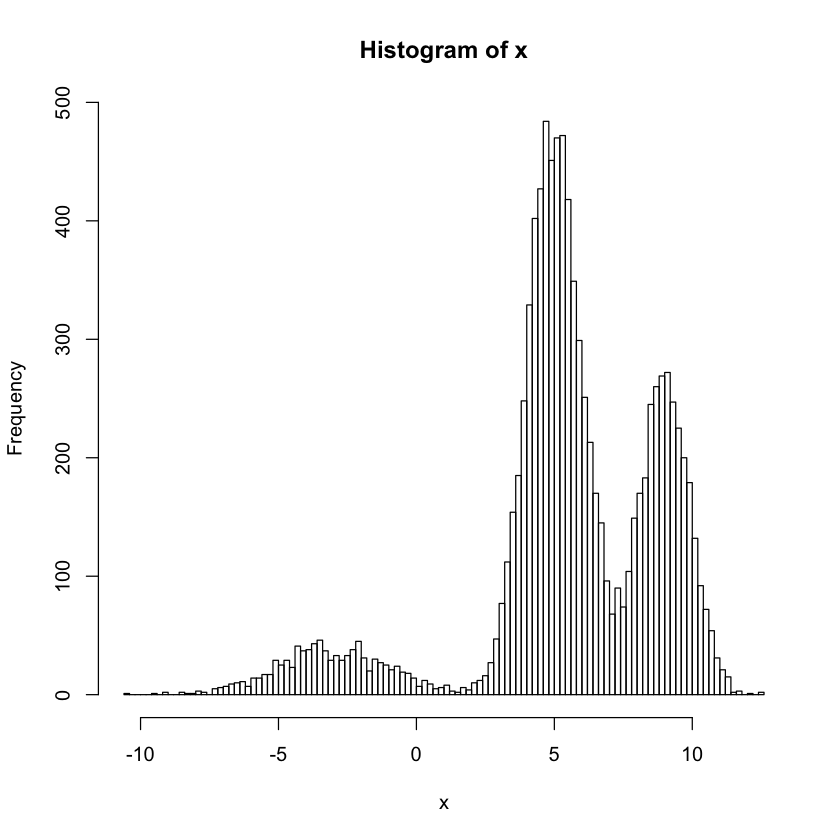

In [33]:
#Univariate Case:
x=rep(NA,10000)
x=sapply(x, function(x){
    class=sample(c(1,2,3), size=1,replace = TRUE, prob = c(.1,.6,.3))
    return(c(rnorm(n=1,mean=-3,sd=2),rnorm(n=1,mean=5,sd=1),rnorm(n=1,mean=9,sd=.9))[class])
})
hist(x,nclass=100)

In [37]:
#Univariate Case:
x=rep(NA,10000)
x=sapply(x, function(x){
    class=sample(c(1,2,3), size=1,replace = TRUE, prob = c(.1,.6,.3))
    return(c(rnorm(n=1,mean=-3,sd=2),rnorm(n=1,mean=5,sd=1),rnorm(n=1,mean=9,sd=.9))[class])
})
library(mixtools)
mixture<-normalmixEM(x,k=3,fast=TRUE)
summary(mixture)

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



number of iterations= 28 
summary of normalmixEM object:
           comp 1   comp 2   comp 3
lambda  0.0954482 0.603725 0.300826
mu     -3.0379480 4.992321 8.979262
sigma   1.9857141 0.996593 0.905671
loglik at estimate:  -22978.71 


$\textbf{EM Algorithm:}$

Before we consider the EM algorithm, let us first review how we would estimate the parameters if the latent variable value were known.

          [,1]     [,2]
[1,]  0.174000 0.826000
[2,] -2.959185 5.007041
[3,]  2.072673 1.000652


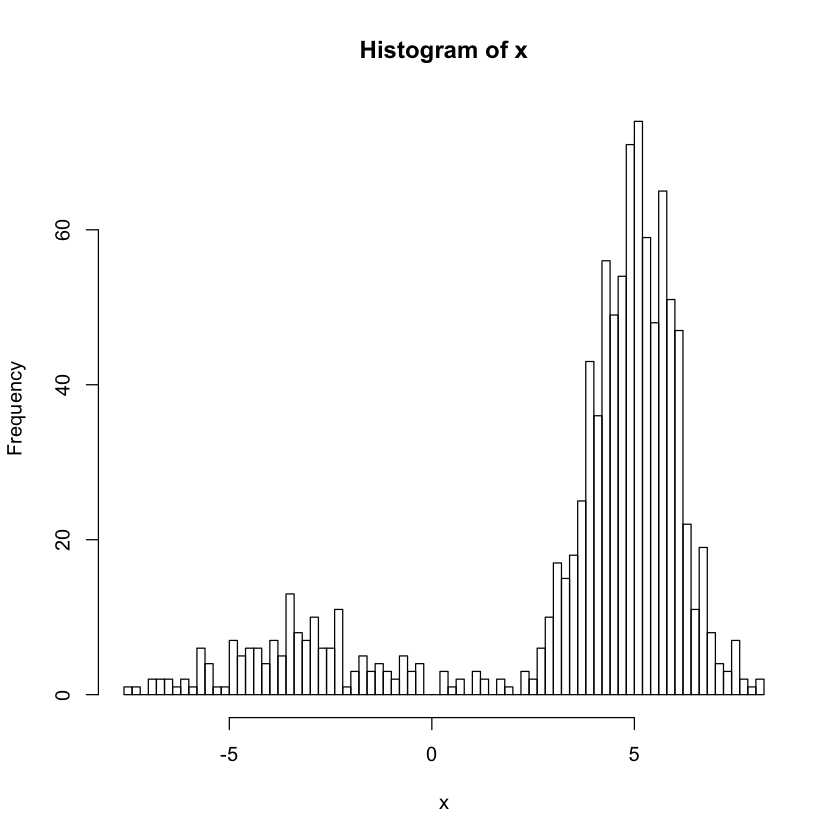

In [83]:
n=1000
x=rep(NA,n)
class=sample(c(1,2), size=n,replace = TRUE, prob = c(.2,.8))
x=sapply(class, function(x) if(x==1){rnorm(n=1,mean=-3,sd=2)}else{rnorm(n=1,mean=5,sd=1)})
hist(x, nclass=100)

print(cbind(c(mean(class==1),mean(x[class==1]),sd(x[class==1])),c(mean(class==2),mean(x[class==2]),sd(x[class==2]))))

$\textbf{EM algorithm:}$

-Choose "good" initial parameter estimates (this is pretty important)

-Assign each point to one of the distributions based on which one most likely generated it. (Expectation)

-Pretend the labels are correct and then use MLE to re-estimate the parameters for each distribution. (Maximization)

-Repeat Expectation and Maximization steps until convergence (i.e. until loglikelihoods differ by less than $\epsilon$ between iterations).

In [127]:
set.seed(1)
x=rep(NA,1000)
x=sapply(x, function(x){
    class=sample(c(1,2), size=1,replace = TRUE, prob = c(.1,.9))
    return(c(rnorm(n=1,mean=-3,sd=2),rnorm(n=1,mean=5,sd=1))[class])
})
library(mixtools)
mixture<-normalmixEM(x,k=2,fast=TRUE)
summary(mixture)


# initial values
cutoff=1 #(technically we should obtain this with k means- which itself is just algorithm where we make putative cluster centers, calculate cluster label for each point, and then move cluster center to mean of the points assigned to it)
mu1= mean(x[x<1])
mu2=mean(x[x>=1])
sd1= sd(x[x<1])
sd2=sd(x[x>=1])
pi1= mean(x<1)
pi2=mean(x>=1)
# loop
llprev=1
ll=0
k=0
while(abs(ll-llprev) >= 0.00001) {
  if(k >  1000){
    print("Did not converge")
    break
  }
  # E step
  c1 <- dnorm(x, mu1, sd1) * pi1
  c2 <- dnorm(x, mu2, sd2) * pi2
  denom <- c1 + c2
  post1 <- c1 / denom
  post2 <- c2 / denom
  llprev=ll
  ll <- sum(log(denom, base = exp(1)))
  
  # M step
  c1.n <- sum(post1)
  c2.n <- sum(post2)
  
  mu1 <- 1/c1.n * sum(post1 * x)
  mu2 <- 1/c2.n * sum(post2 * x)
  
  sd1 <- sqrt(sum(post1 * (x - mu1)^2) * 1/c1.n)
  sd2 <- sqrt(sum(post2 * (x - mu2)^2) * 1/c2.n)
  
  pi1 <- c1.n / length(x)
  pi2 <- c2.n / length(x)
  k=k+1
  
}
print(paste0("iterations: ",k))
print(cbind(c(pi1,mu1,sd1),c(pi2,mu2,sd2)))

number of iterations= 30 
summary of normalmixEM object:
           comp 1   comp 2
lambda  0.0949321 0.905068
mu     -2.7506347 5.004554
sigma   2.1831475 1.021161
loglik at estimate:  -1815.715 
[1] "iterations: 12"
            [,1]      [,2]
[1,]  0.09492975 0.9050702
[2,] -2.75075794 5.0045467
[3,]  2.18302644 1.0211704


The above exercise is useful if we want to know the parameters of the distribution (i.e. for a better scientific understanding of the distribution of x and the latent factor affecting it), but this approach also provides us with a way to cluster on x, dividing the observations according to their level of the latent factor.

However, this example also provides a word of caution on hidden variable models in general- if the hidden variable is not actually hidden then we should probably use it as part of a heirarchical model rather than leaving it as latent.

Andrew Gellman gives the example of election forecasting: our goal is to predict winners and losers based on things we can see prior to the election, but if we simply do logistic regression we will handicap ourselves. Why? Because in close elections, where the winner wins by 1 vote, no model should be able to accurately predict the winner. But in logistic regression we are unfairly penalizing the model for being wrong or unfairly rewarding it for being right in these cases. There is a huge latent variable- proportion of vote won- that is (deterministically) influencing the outcome. This is observable post facto, so we should include it in our model.

$\textbf{Short Digression into K-Means:}$

Note that EM algorithm is K means, just with a different distance metric.
Intialize random centers

Repeat until done:
1) for each point find closest center, and assign it to that cluster (Expectation)
2) Replace each center with the coordinatewise average of all points that are assigned to it. (Maximization)

Algorithm converges to a local minimum of the within cluster sum of squares.


EM: for Gaussian- soft k-Means


$\textbf{Mixture of Experts:}$ 

Similar to GMM- now, we may, for example, do "Mixture Regression", with a hidden class variable that determines the slope of the regression line for the points from that class.
    
$$p(Y=y|X=x,Z=z) = N(y|x\beta_z, \sigma^2_z)$$
$$p(Z=z|X=x) = Cat(z|xV)$$

where $\beta_z$, $\sigma^2_z$ and $V$ are parameters to estimate.

As before, after computing the MLE we can sum the product of these likehoods over Z to get p(Y=y|X=x).



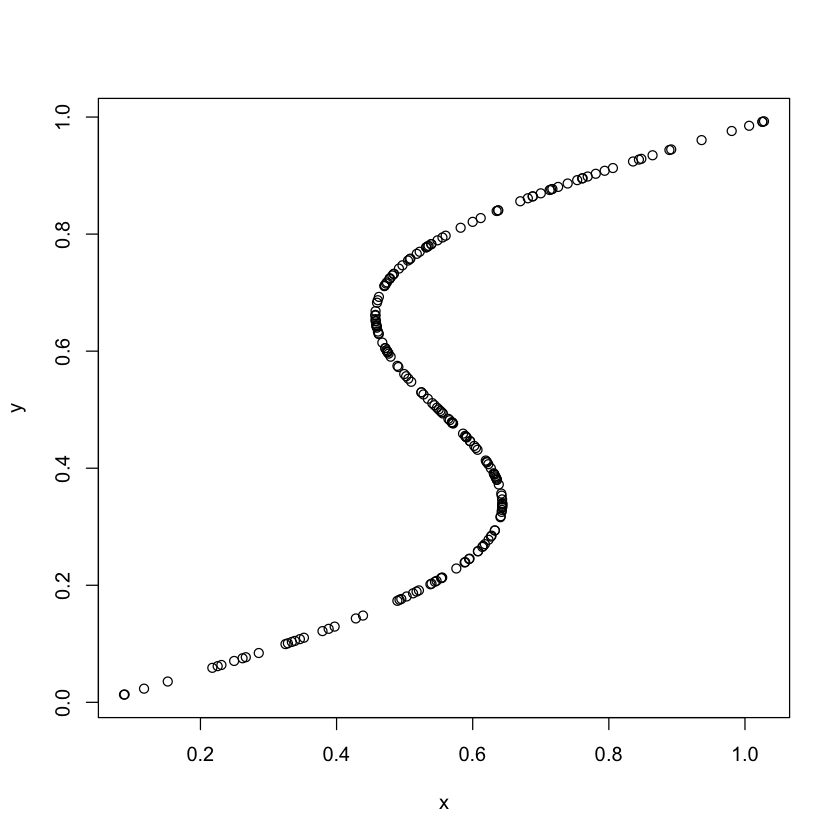

In [107]:
#Mixutre of Experts:
library(mixtools)
pi=3.14
set.seed(1)
n = 200
y = runif(n)
eta = 0.05
x = y + 0.3*sin(2*pi*y) + eta
data = cbind(x,y)
plot(y~x)

number of iterations= 27 
summary of regmixEM object:
           comp 1     comp 2    comp 3
lambda  0.2554417  0.4253195 0.3192388
sigma   0.0145594  0.0165173 0.0165531
beta1  -0.0557750  1.3417946 0.4981831
beta2   0.5010664 -1.5300936 0.5077018
loglik at estimate:  329.6519 


,comp.1,comp.2,comp.3
beta.0,-0.05577498,1.341795,0.4981831
beta.1,0.50106637,-1.530094,0.5077018


NULL

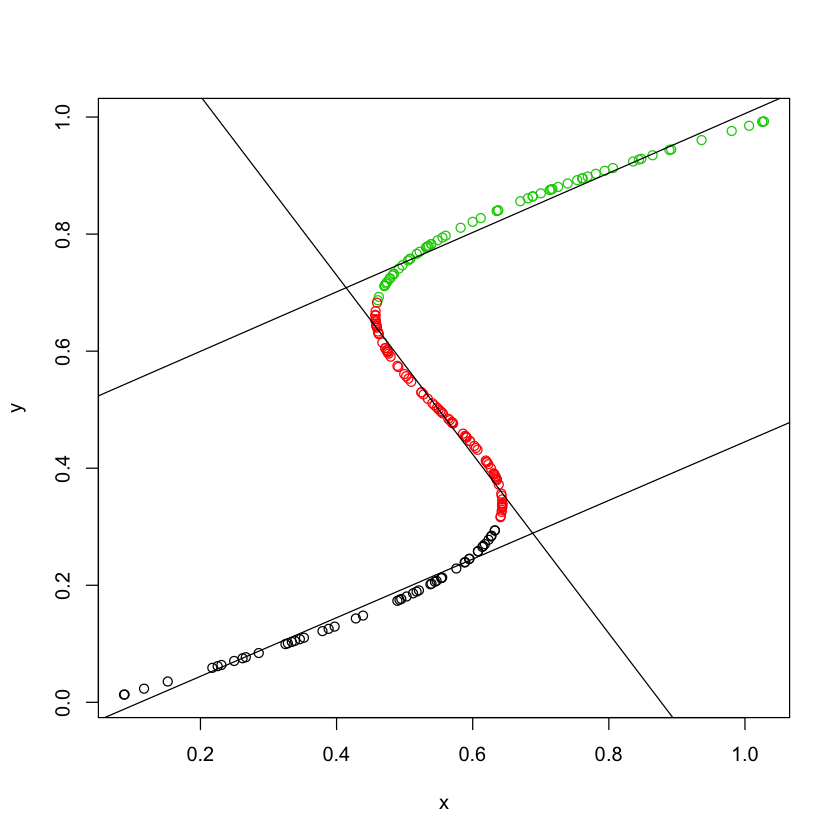

In [108]:
K = 3
rm=regmixEM(y,x,k=3)
summary(rm)
rm$beta
plot(y~x, col=apply(rm$posterior,1, which.max))
apply(rm$beta, 2, function(x) abline(a = x[1],b =x[2] ))

Of course in this case you could also observe the sinusoidal shape, and fit x as a function of y, which would be much more informative. That said, unless you are really poring over the data, or unless you were in a science or engineering environment were you might expect this relationship, the mixture of experts might be more practical.

Warning message in summary.lm(m1):
“essentially perfect fit: summary may be unreliable”


Call:
lm(formula = x ~ y + I(sin(2 * pi * y)))

Residuals:
       Min         1Q     Median         3Q        Max 
-2.866e-16 -8.260e-17 -2.830e-17  9.600e-18  5.738e-15 

Coefficients:
                    Estimate Std. Error   t value Pr(>|t|)    
(Intercept)        5.000e-02  1.027e-16 4.867e+14   <2e-16 ***
y                  1.000e+00  1.930e-16 5.182e+15   <2e-16 ***
I(sin(2 * pi * y)) 3.000e-01  7.162e-17 4.189e+15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.226e-16 on 197 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.343e+31 on 2 and 197 DF,  p-value: < 2.2e-16


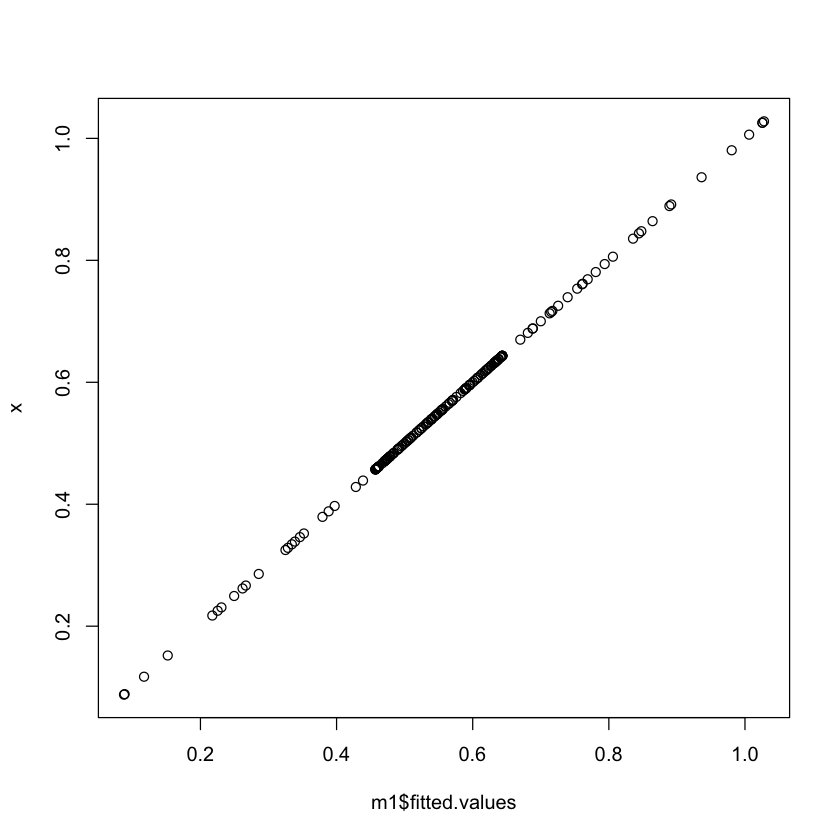

In [120]:
m1=lm(x~y+I(sin(2*pi*y)))
summary(m1)
plot(x~m1$fitted.values)

$\textbf{Parameter Estimation Revisited:}$

Statisticians like MLE, because it has great properties, but those properties are predictated on actually maximizing it. But maximization is very difficult in non-convex spaces.

First, there is the problem of identifiability.
In its simplest form it is equivalent to the idea of label switching- i.e. suppose we have $$.5N(\mu_1,1)+.5N(\mu_2,1)$$
Then the $\mu$'s are cleaerly interchangeable, and hence we cannot say what the value of either is.
Now, we can of course say "we don't care about label switch, we know that we can't know the true labels."
But this presents a deeper problem: Suppose we try MCMC. we have to make sure that we aren't averaging between modes, otherwise our results would be meaningless. Specifically, we have to partition the space along the axis of symmetry and then stay on one side, then, after we have that distribution, we could mirror it. But this example still requires knowing the mixture parameter. So, there are lots of attempted solutions, but it is very difficult.


Second there is the issue of non-convexity, which means that in subexponential time we can only guarantee local minima. One solution is multiple random starts, but this doesn't actually solve anything, since we can't make any reasonable claim about the probability of having found the global minima given k random starts.